# Projeto prático #4 - Modelo para classificação de sementes de trigo

Equipe:

- Lucas Frota
- Wilson neto

# 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np

from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from math import ceil

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter("ignore")

# 2. funções uteis

In [3]:
def cast_tab_to_comma_separated_values(file_name):
    '''
    esta função converte um arquivo com valores separados por tabulação em um dataframe com valores do tipo float
    '''
    datasetlines = open(file_name, "r").readlines()
    df_list = []
    for line in datasetlines:
        line = line.replace("\n", "")
        line = line.split("\t")
        line = [float(i) for i in line if(i != '')]
        df_list.append(line)
       
    return pd.DataFrame(df_list)

In [4]:
def plot_mult_histograms(df, columns, has_legend=True):
    '''
    esta função mostra um histograma com determinadas colunas de um dataframe
    '''
    for column in columns:
        plt.hist(df[column], label=column)
        
    if(has_legend):
        plt.legend()
    plt.show()

In [5]:
def plot_combination(df, x, y):
    '''
    esta função mostra um grafico com os pontos coloridos de acordo com a clase que ele pertence, 
    x e y são as colunas do dataframe que se deseja comparar
    '''
    df_class_1 = df.loc[df['target'] == 1.0]
    df_class_2 = df.loc[df['target'] == 2.0]
    df_class_3 = df.loc[df['target'] == 3.0]
    
    plt.scatter(df_class_1[x], df_class_1[y], c='b')
    plt.scatter(df_class_2[x], df_class_2[y], c='r')
    plt.scatter(df_class_3[x], df_class_3[y], c='g')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [6]:
piramide_geometrica = lambda alpha, ni , no: ceil(alpha * (( ni * no )**0.5))

In [7]:
def creat_layers_set(num):
    layers = []
    aux_num = 0
    while num >= 0:
        if(num != 0 and aux_num != 0):
            layers.append((num, aux_num))
        elif(aux_num == 0):
            aux = "(" + str(num) + ",)"
            layers.append(eval(aux))
        num -= 1
        aux_num += 1
        
    return layers

In [8]:
get_layers = lambda alpha, ni, no: creat_layers_set(piramide_geometrica(alpha, ni, no))

# 3. Fase de limpeza dos dados

Inicialmente nos iremos tranformar o dataset original que esta separado por tabs em um dataset separado por virgulas para que ele possa ser manipulado com mais facilidade

In [9]:
df = cast_tab_to_comma_separated_values("dataset.txt")

Para facilitar a analize dos dados aqui nos iremos nomear cada coluna

In [10]:
df.columns = ["area", "perimeter",
              "compactness", 
              "length_of_kernel", 
              "width_of_kernel", 
              "asymmetry_coefficient",
              "length_of_kernel_groove", 
              "target"]

Para que seja possivel fazer uma classificação e nao uma regressão aqui o atributo tarqet sera tranformado do tipo float para o tipo string

In [11]:
df['target'] = df['target'].apply(lambda x: str(int(x)))

Visando evitar erros nos testes este dataset sera randomizado

In [12]:
df = shuffle(df)

Agora temos o dataset pronto para analiza e treinamento dos modelos

In [13]:
df.head()

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,target
21,14.11,14.26,0.8722,5.520,3.168,2.688,5.219,1
151,12.01,13.52,0.8249,5.405,2.776,6.992,5.270,3
99,18.72,16.34,0.8810,6.219,3.684,2.188,6.097,2
47,14.99,14.56,0.8883,5.570,3.377,2.958,5.175,1
101,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,2


# 4. Analize dos dados

O numero de instancias deste dataset é mostrado abaixo

In [14]:
len(df)

210

Dentre as 210 instancias não ha valores faltando em nenhuma das colunas

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 21 to 137
Data columns (total 8 columns):
area                       210 non-null float64
perimeter                  210 non-null float64
compactness                210 non-null float64
length_of_kernel           210 non-null float64
width_of_kernel            210 non-null float64
asymmetry_coefficient      210 non-null float64
length_of_kernel_groove    210 non-null float64
target                     210 non-null object
dtypes: float64(7), object(1)
memory usage: 14.8+ KB


Existem exatamente 70 exemplos de cada classe, desta forma este é um dataset balanciado

In [16]:
df["target"].value_counts()

1    70
3    70
2    70
Name: target, dtype: int64

A matriz abaixo é muito util para mostrar corelações entre todos os elementos combinados dois a dois, atravez dela é possivel entender de uma forma ituitiva se as classes são separaveis em duas dimensões quando combinadas dessa forma.

- Por se tratar de um dataset com tres classes não há como separa-los utilizando apenas uma linha reta.
- No caso deste dataset é possível ver de forma intuitiva quais grupos são mais facilmente separaveis
- Os grupos que apresentam pontos mais juntos estão mais relacionados
- Os graficos mostram que o atributo **area** esta altamente relacionada as atributos **perimeter**, **length_of_kernel**, **width_of_kernel** e **length_of_kernel_groove**. Esta alta correlação provavelmente ocorre pelo fato de a area ser um atributo calculado atravez desses parametros
- O atributo **perimeter** esta tambem altamente correlacionado com os atributos **length_of_kernel** e **width_of_kernel** provavelmente pelo fato de ele ser calculado atravez desses atributos

### 4.1 pairplot 1

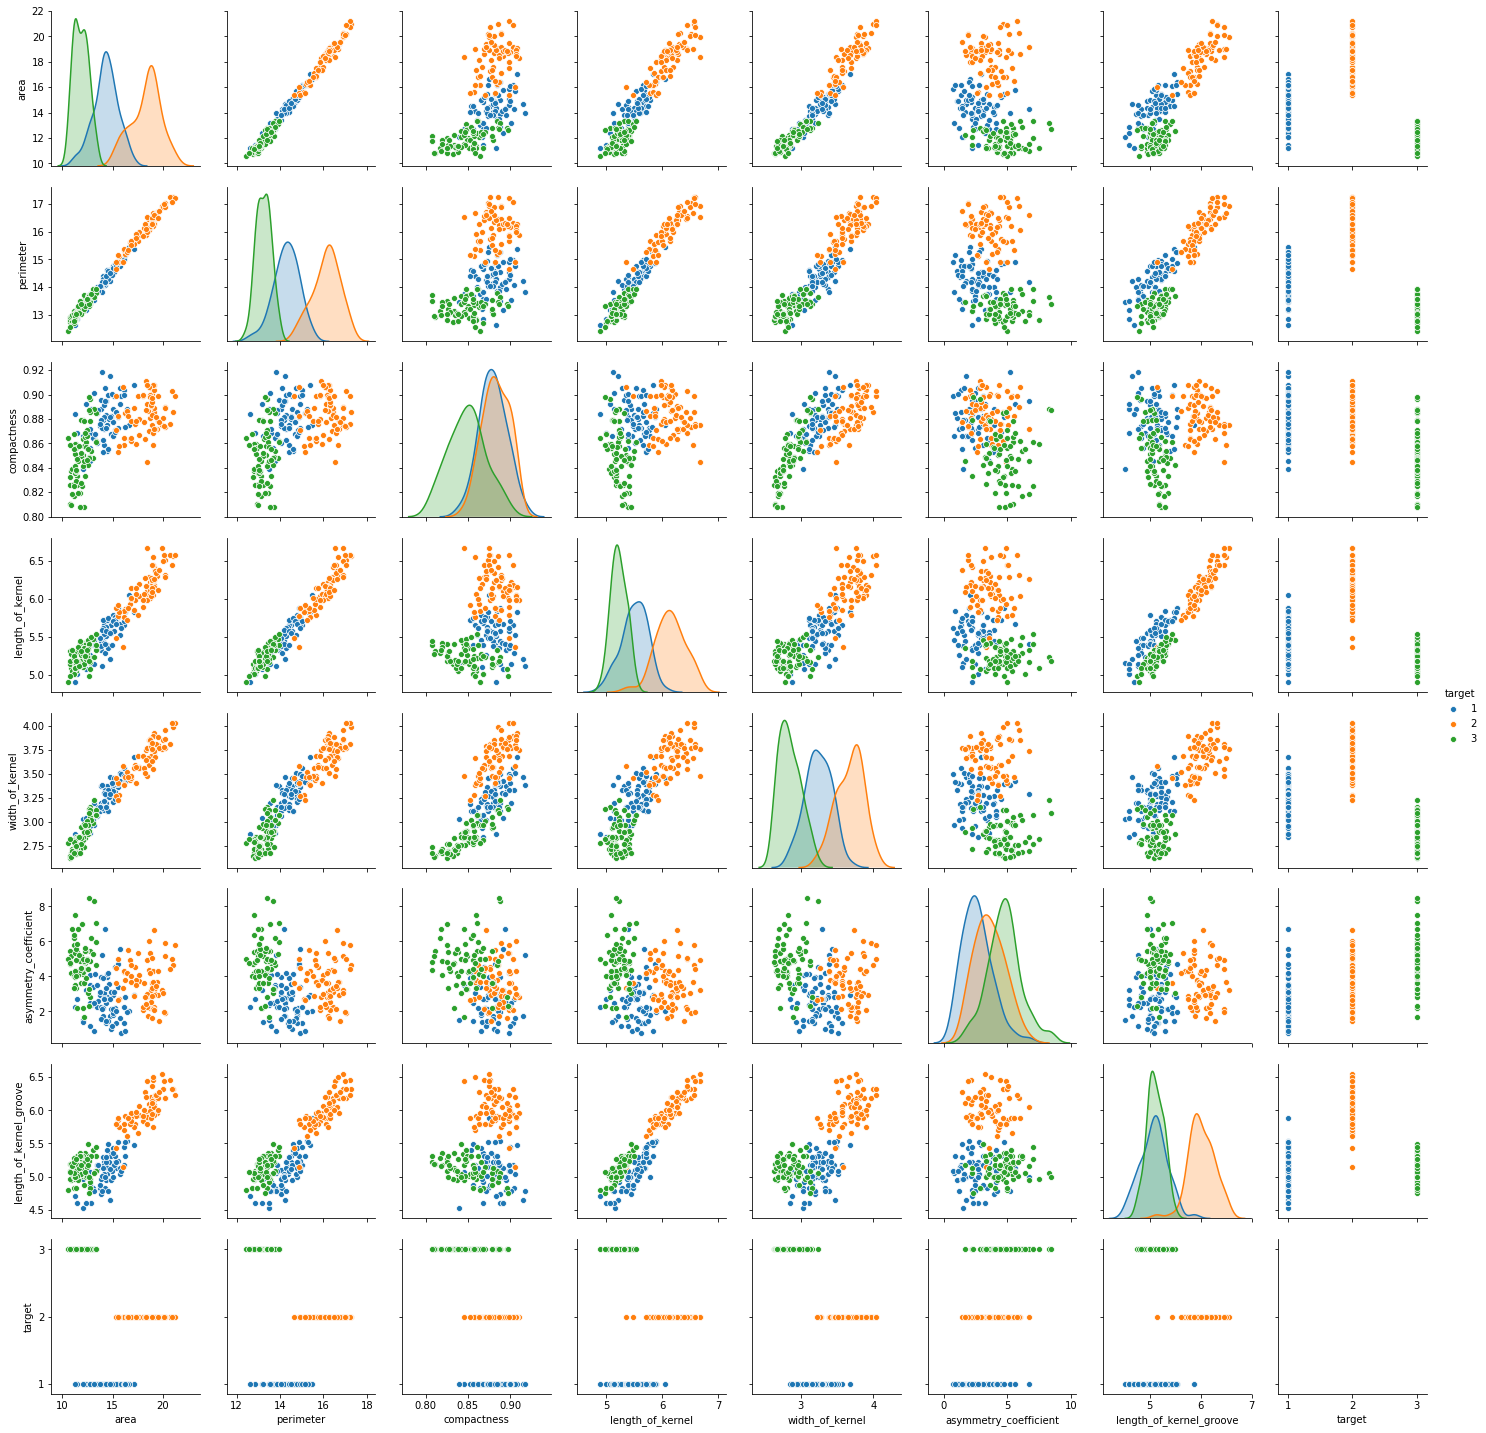

In [17]:
sns.pairplot(df, hue="target")

Para ter uma noção mais precisa sobre a corelação entre os elementos combinados dois a dois aqui nos utilizamos uma tabela com o calculo das correlações

In [18]:
corr = df.corr()
corr

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove
area,1.000000,0.994341,0.608288,0.949985,0.970771,-0.229572,0.863693
perimeter,0.994341,1.000000,0.529244,0.972422,0.944829,-0.217340,0.890784
compactness,0.608288,0.529244,1.000000,0.367915,0.761635,-0.331471,0.226825
length_of_kernel,0.949985,0.972422,0.367915,1.000000,0.860415,-0.171562,0.932806
width_of_kernel,0.970771,0.944829,0.761635,0.860415,1.000000,-0.258037,0.749131
asymmetry_coefficient,-0.229572,-0.217340,-0.331471,-0.171562,-0.258037,1.000000,-0.011079
length_of_kernel_groove,0.863693,0.890784,0.226825,0.932806,0.749131,-0.011079,1.000000


### 4.2 pairplot 2

Consideranco a grande correlação entre o atributo **area** e outros atributos pode ser interessante separa-lo do resto para observar qual o efeito disso

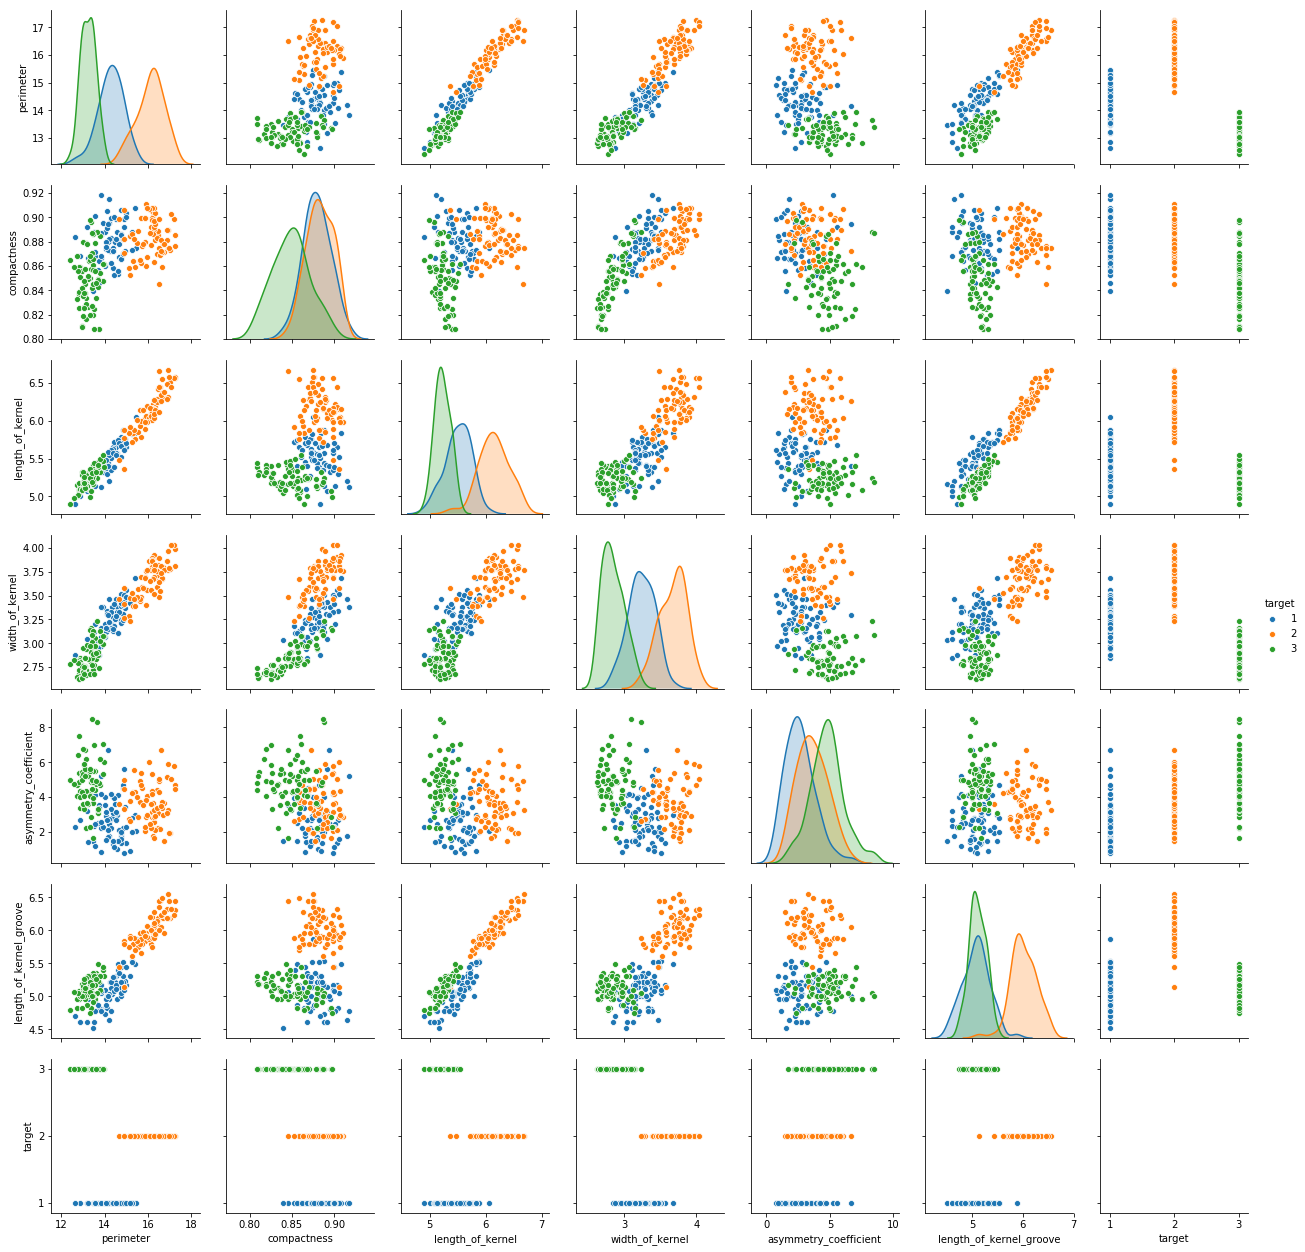

In [19]:
sns.pairplot(df[df.columns[1:]], hue="target")

### 4.3 pairplot 3

A partir dos graficos acima é possivel ver que **perimeter** tambem possui uma auta correlação com **length_of_kernel** e **width_of_kernel**, por iremos retirar o atributo **perimeter** e gerar o grafico novamente para poder observar os efeitos da mudança

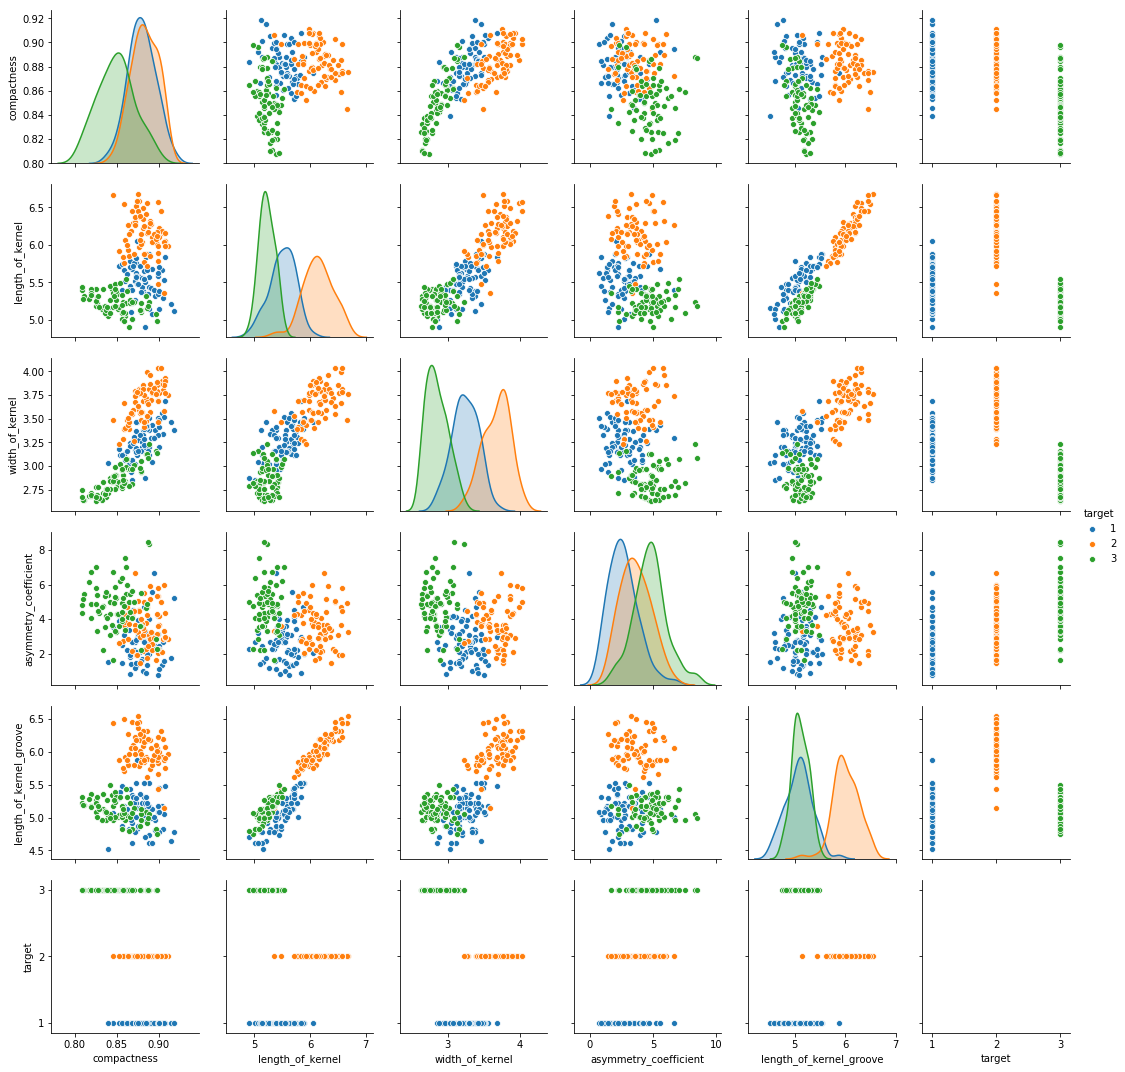

In [20]:
sns.pairplot(df[df.columns[2:]], hue="target")

### 4.4 Hipóteses de modelos

Agora temos tres possiveis datasets

- O dataset original sem nenhuma alteração
- O dataset sem o atributo **area**
- O dataset sem os atributos **area** e **perimeter**

Assim partindo do principio de que informações muito corelacionadas serão mais difíceis de serem classificadas por uma rede neural nos testaremos essas tres configurações de dataset para verificar se a retirada desses parametros afeta possitivamente o treinamento dos modelos.

# 5. Testes de modelos

Aqui criamos um X para cada configuração proposta

In [21]:
X_1 = df[df.columns[:-1]]
X_2 = X_1[X_1.columns[1:]]
X_3 = X_1[X_1.columns[2:]]
y = df[df.columns[-1:]]

A quantidade de neuronios foi definida atravez da regra da piramide geometrica, aqui implementada na função **get_layers** que foi definida no topico [2. funções uteis](#2.-funções-uteis), ela retorna uma lista com as combinações de tuplas que podem ser feitas de tal forma que o numero total de neuronios é igual ao resultado da regra da piramide

In [22]:
output_size = 3
input_size_x_1 = X_1.shape[1]
input_size_x_2 = X_2.shape[1]
input_size_x_3 = X_3.shape[1]

In [23]:
layers_1 = []
layers_2 = []
layers_3 = []

layers_1 += get_layers(0.5, input_size_x_1, output_size)
layers_1 += get_layers(2, input_size_x_1, output_size)
layers_1 += get_layers(3, input_size_x_1, output_size)

layers_2 += get_layers(0.5, input_size_x_2, output_size)
layers_2 += get_layers(2, input_size_x_2, output_size)
layers_2 += get_layers(3, input_size_x_2, output_size)

layers_3 += get_layers(0.5, input_size_x_3, output_size)
layers_3 += get_layers(2, input_size_x_3, output_size)
layers_3 += get_layers(3, input_size_x_3, output_size)

Aqui definiremos os parametros que serão combinados pelo **GridSearchCV**, criaremos tres conjuntos de parametros para testar as tres configurações de dataset propostas anteriormente

In [24]:
activation_functions = ['identity', 'logistic', 'tanh', 'relu']

Utilizaremos o solver **lbfgs**, pois a [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) da classe **MLPClassifier** inidca que esse é o melhor solver para situações com datasets pequenos.

In [25]:
parameters_1 = {'hidden_layer_sizes':layers_1, 
                'activation':activation_functions, 
                'solver':['lbfgs']}

parameters_2 = {'hidden_layer_sizes':layers_2, 
                'activation':activation_functions, 
                'solver':['lbfgs']}

parameters_3 = {'hidden_layer_sizes':layers_3, 
                'activation':activation_functions, 
                'solver':['lbfgs']}

In [26]:
classifier_1 = GridSearchCV(MLPClassifier(), parameters_1, cv=3, scoring="accuracy")
classifier_2 = GridSearchCV(MLPClassifier(), parameters_2, cv=3, scoring="accuracy")
classifier_3 = GridSearchCV(MLPClassifier(), parameters_3, cv=3, scoring="accuracy")

### 5.1 Teste do modelo 1

In [27]:
classifier_1.fit(X_1, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(3,), (2, 1), (1, 2), (10,), (9, 1), (8, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (2, 8), (1, 9), (14,), (13, 1), (12, 2), (11, 3), (10, 4), (9, 5), (8, 6), (7, 7), (6, 8), (5, 9), (4, 10), (3, 11), (2, 12), (1, 13)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Acuracia:

In [28]:
classifier_1.best_score_

0.9666666666666667

### 5.2 Teste do modelo 2

In [29]:
classifier_2.fit(X_2, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(3,), (2, 1), (1, 2), (9,), (8, 1), (7, 2), (6, 3), (5, 4), (4, 5), (3, 6), (2, 7), (1, 8), (13,), (12, 1), (11, 2), (10, 3), (9, 4), (8, 5), (7, 6), (6, 7), (5, 8), (4, 9), (3, 10), (2, 11), (1, 12)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Acuracia:

In [30]:
classifier_2.best_score_

0.9571428571428572

### 5.3 Teste do modelo 3

In [31]:
classifier_3.fit(X_3, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(2,), (1, 1), (8,), (7, 1), (6, 2), (5, 3), (4, 4), (3, 5), (2, 6), (1, 7), (12,), (11, 1), (10, 2), (9, 3), (8, 4), (7, 5), (6, 6), (5, 7), (4, 8), (3, 9), (2, 10), (1, 11)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Acuracia:

In [32]:
classifier_3.best_score_

0.9523809523809523

# 6. Conclusão

In [33]:
quantity_of_models_1 = len(classifier_1.grid_scores_)
quantity_of_models_2 = len(classifier_2.grid_scores_)
quantity_of_models_3 = len(classifier_3.grid_scores_)

Os modelos propostos quando submetidos ao **GridSearch** geraram as seguintes quantidades de redes naurais

In [34]:
print("classifier_1: " + str(quantity_of_models_1))
print("classifier_2: " + str(quantity_of_models_2))
print("classifier_3: " + str(quantity_of_models_3))

classifier_1: 108
classifier_2: 100
classifier_3: 88


A quantidade total de modelos gerados foi:

In [35]:
print("Total de modelos: " + str(quantity_of_models_1 + quantity_of_models_2 + quantity_of_models_3))

Total de modelos: 296


Atravez da comparação entre as acuracias geradas utilizando as configurações de dataset propostas é possivel notar que a diferença entre eles é muito pequena, e por isso [proposição inicial](#4.4-Hipóteses-de-modelos) não se mostra interessante neste caso.

Tendo isso em vista iremos eleger o primeiro dataset, ou seja o dataset original com todos os dados, como melhor de todos, pois apesar de a area e o perimetro serem valores calculados a partir de outros valores as sementes não possuem formas muito regulares, assim nem toda as informações sobre as dimenções da semenete estão perfeitamente contidas em um unico parametro

Uma vez com o melhor dataset escolhido é necessario escolher qual a melhor conjunto de parametros, esta tarefa foi feita atravez da classe **GridSearchCV**, a melhor combinação escolhida levando em conta a acurácia e a acuracia foram:

In [36]:
best_model = classifier_1.best_params_

print("Melhores Parametros: ")
print(" * Função de ativação: " + best_model["activation"])
print(" * Dimensões da camada oculta: " + str(best_model["hidden_layer_sizes"]))
print(" * Solver: " + best_model["solver"])

print()
print("Melhor acurácia: " + str(classifier_1.best_score_))

Melhores Parametros: 
 * Função de ativação: identity
 * Dimensões da camada oculta: (11, 3)
 * Solver: lbfgs

Melhor acurácia: 0.9666666666666667


Os valores acima podem variar de acordo com a execução